# Importar librerías

In [ ]:
!pip install chess
!pip install stockfish
!pip install Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 17.9 MB/s eta 0:00:00


In [ ]:
import re
import time
import math
import random
from IPython.display import SVG, display
# Ajedrez
import chess # https://python-chess.readthedocs.io/en/latest/
import chess.svg
from stockfish import Stockfish # https://pypi.org/project/stockfish/
# Google Colab
import gdown
# Limpieza de memoria
import gc
# NLP
import torch
import Levenshtein
from transformers import pipeline

Descargar Stockfish 16, módulo de evaluación de ajedrez. Documentación del módulo en https://stockfishchess.org/download/

In [ ]:
gdown.download('https://drive.google.com/uc?id=1ocFgnNSyB915fGQg04ZGSNqlG5OAsGLX', quiet=False) # stockfish 16

Downloading...
From: https://drive.google.com/uc?id=1ocFgnNSyB915fGQg04ZGSNqlG5OAsGLX
To: /content/stockfish-ubuntu-x86-64-avx2.tar
100%|██████████| 41.6M/41.6M [00:00<00:00, 94.3MB/s]


'stockfish-ubuntu-x86-64-avx2.tar'

In [ ]:
!tar -xf 'stockfish-ubuntu-x86-64-avx2.tar'

# Motor NLU

Diccionarios auxiliares

In [ ]:
PIEZAS_ES_SAN = {'alfil':'B','dama':'Q','reina':'Q','torre': 'R', 'caballo':'N', 'rey':'K', 'peon':''} # no se coloca la P para peón
PIEZAS_EN_SAN = {'king':'K','queen':'Q','rook':'R','knight':'N','bishop':'B','pawn':'P'}
PIEZAS_SAN_EN = {'K':'king','Q':'queen','R':'rook','N':'knight','B':'bishop','P':'pawn'}

PIEZAS_ES_EN = {'C': 'N','A': 'B','D': 'Q','R': 'K','T': 'R' }  # traducir Torre después de Rey
PIEZAS_EN_ES = {'N': 'C','B': 'A','Q': 'D','R': 'T','K': 'R'} # traducir Rey después de Torre
PIEZAS_PYTHON = {'': chess.PAWN,'N': chess.KNIGHT,'B': chess.BISHOP,'R': chess.ROOK,'Q': chess.QUEEN, 'K': chess.KING} # traducir Rey después de Torre

SPELL_KW = ['tablas','tablitas','empate','abandono','salir','enroque','largo','corto','mejores','mejor','opciones','opcion','movimientos','movimiento','curiosidades','curiosidad','curioso','jugadas','movida','movidas']

Patrones REGEX

In [ ]:
SAN_ES_RE = r'^[TCADR]?[a-h]?[1-8]?[x]?[a-h][1-8](=[TCADR])?[+#]?$'
SAN_EN_RE = r'^[RNBQK]?[a-h]?[1-8]?[x]?[a-h][1-8](=[RNBQK])?[+#]?$'
SAN_ENROQUE_RE = r'^(O-O(-O)?|OOO?|000?|0-0(-0)?)[+#]?$'
PROMOCION_W_RE = '[a-h]?[1-8]?[x]?[a-h]8'
PROMOCION_B_RE = r'[a-h]?[1-8]?[x]?[a-h]1'

Validación de notación algebraica estándar

In [ ]:
def val_san_es(cadena):
  #cadena_limpia = cadena.replace(' ','') # quitar espacios
  patron_movimiento = re.compile(SAN_ES_RE)
  patron_enroque = re.compile(SAN_ENROQUE_RE)
  return bool(patron_movimiento.match(cadena)) or bool(patron_enroque.match(cadena))

def val_san_en(cadena):
  #cadena_limpia = cadena.replace(' ','') # quitar espacios
  patron_movimiento = re.compile(SAN_EN_RE)
  patron_enroque = re.compile(SAN_ENROQUE_RE)
  return bool(patron_movimiento.match(cadena)) or bool(patron_enroque.match(cadena))

Funciones de traducción de SAN en español (usada x el usuario) a inglés (usada x python)

In [ ]:
def traducir_san_en(san_es):
  traduccion_dic = PIEZAS_ES_EN

  san_en = san_es
  for es_char, en_char in traduccion_dic.items():
    san_en = san_en.replace(es_char, en_char)

  return san_en

def traducir_san_es(san_en):
  traduccion_dic = PIEZAS_EN_ES

  san_es = san_en
  for en_char, es_char in traduccion_dic.items():
    san_es = san_es.replace(en_char, es_char)

  return san_es

In [ ]:
val_notacion_test = {'Te1': True,'Cf3': True,'exd5': True,'Te1': True,'Cf3': True,'exd5': True,'Da1d2': True,'Axe1' : True }

for cadena, resultado_esperado in val_notacion_test.items():
  resultado_obtenido = val_san_es(cadena)
  print(f'{cadena}: ' + ('OK' if resultado_obtenido == resultado_esperado else 'NOK') + ', ' + traducir_san_en(cadena))

Te1: OK, Re1
Cf3: OK, Nf3
exd5: OK, exd5
Da1d2: OK, Qa1d2
Axe1: OK, Bxe1


In [ ]:
patron = re.compile(r'[a-h]?[1-8]?[x]?[a-h]8(=[TCADR])?[+#]?')
resultado = patron.match('Cxe8')
resultado

Función de etiquetado de utterance. Reemplaza las casillas y piezas con etiquetas (#pieza_0#, #casilla_1#, etc). Usa distancia de Levenshtein para corregir pequeños errors ortográficos.

In [ ]:
def etiquetar_cadena(cadena):
  etiquetas_dic = {}
  palabras = cadena.split()

  ipiezas = 0
  icasillas = 0
  for i in range(0, len(palabras)):
    if palabras[i] in PIEZAS_ES_SAN:
      etiqueta = f'#pieza_{ipiezas}#'
      etiquetas_dic[etiqueta] = palabras[i]
      palabras[i] = etiqueta
      ipiezas+=1
    elif re.search(r'[a-h][1-8]', palabras[i]):
      etiqueta = f'#casilla_{icasillas}#'
      etiquetas_dic[etiqueta] = palabras[i]
      palabras[i] = etiqueta
      icasillas+=1
    else:
      for pieza in PIEZAS_ES_SAN:
        distancia = Levenshtein.distance(palabras[i], pieza, weights=(2, 1, 1), score_cutoff=2)
        if distancia <= 2:
          etiqueta = f'#pieza_{ipiezas}#'
          etiquetas_dic[etiqueta] = pieza
          palabras[i] = etiqueta
          ipiezas+=1
          break

      for kw in SPELL_KW:
        distancia = Levenshtein.distance(palabras[i], kw, weights=(2, 1, 1), score_cutoff=2)
        if distancia <= 2:
          palabras[i] = kw
          break


  return ' '.join(palabras), etiquetas_dic

In [ ]:
print(etiquetar_cadena('alfll por a5'))
print(etiquetar_cadena('trre peon a dama doma rei reyna'))
print(etiquetar_cadena('enrroque lrgo'))

('#pieza_0# por #casilla_0#', {'#pieza_0#': 'alfil', '#casilla_0#': 'a5'})
('#pieza_0# #pieza_1# a #pieza_2# #pieza_3# #pieza_4# #pieza_5#', {'#pieza_0#': 'torre', '#pieza_1#': 'peon', '#pieza_2#': 'dama', '#pieza_3#': 'dama', '#pieza_4#': 'rey', '#pieza_5#': 'reina'})
('enroque largo', {})


Función que retorna el intent del usuario a partir del utterance. Busca diferentes patrones en el texto y extrae el movimiento correspondiente

In [ ]:
def nlp_obtiene_intent(utterance, tablero):
  cadena_limpia = re.sub(r'\s+', ' ', utterance).strip()
  cadena_limpia = cadena_limpia.replace('á','a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u')

  intent = None
  slot = None
  hay_patron = False

  if val_san_es(cadena_limpia):
    intent, slot = 'mover', traducir_san_en(cadena_limpia)

  cadena_limpia = cadena_limpia.lower()
  cadena_etiquetada, dic_etiquetas = etiquetar_cadena(cadena_limpia)

  patrones_dic = {
      'pieza_a_casilla': r'(#pieza_\d+#) a (#casilla_\d+#)',
      'pieza_casilla': r'(#pieza_\d+#) (#casilla_\d+#)',

      'casilla_a_casilla': r'(#casilla_\d+#) a (#casilla_\d+#)',
      'casilla_casilla': r'(#casilla_\d+#) (#casilla_\d+#)',
      'casilla_por_casilla': r'(#casilla_\d+#) (por|x) (#casilla_\d+#)',

      'enroque_largo': r'\benroque largo\b',
      'enroque_corto': r'\benroque corto\b',
      'enroque': r'\benroque\b',

      'pieza_por_casilla': r'(#pieza_\d+#) (por|x|a|a la casilla|hacia|hacia la casilla) (#casilla_\d+#)',
      'pieza_por_pieza': r'(#pieza_\d+#) (por|x) (#pieza_\d+#)',
      'pieza_pieza': r'(#pieza_\d+#) (#pieza_\d+#)',
      'pieza_por': r'(#pieza_\d+#) (por|x)',
      'casilla_por': r'(#casilla_\d+#) (por|x)',

      'tablas': r'\b(tablas|tablitas|empate)\b',
      'abandono': r'\b(gg|abandono|salir)\b',

      'hint_best_moves': r'\b(mejores|mejor).*(opcion|opciones|movimientos|movimiento|jugadas|jugada|movidas|movida)\b',
      'hint_moves': r'\b(opcion|opciones|movimientos|movimiento|ayuda|jugadas|jugada|movidas|movida)\b',
      'fact': r'\b(curiosidad|curiosidades|curioso)\b',
  }

  if intent == None:
    for nombre_patron, patron in patrones_dic.items():
      patron = re.compile(patron)
      resultado = patron.findall(cadena_etiquetada)
      if resultado:
        hay_patron = True
        if nombre_patron in ['pieza_casilla','pieza_a_casilla']:
          pieza_etiqueta = resultado[0][0]
          pieza_nombre = dic_etiquetas[pieza_etiqueta]
          pieza_san = PIEZAS_ES_SAN[pieza_nombre]
          casilla_etiqueta = resultado[0][1]
          casilla_san = dic_etiquetas[casilla_etiqueta]
          intent, slot = 'mover', f'{pieza_san}{casilla_san}'
          break

        elif nombre_patron in ['casilla_casilla','casilla_a_casilla']:
          casilla1_etiqueta = resultado[0][0]
          casilla1_san = dic_etiquetas[casilla1_etiqueta]
          casilla2_etiqueta = resultado[0][1]
          casilla2_san = dic_etiquetas[casilla2_etiqueta]
          intent, slot = 'mover', f'{casilla1_san}{casilla2_san}'
          break

        elif nombre_patron in ['casilla_por_casilla']:
          casilla1_etiqueta = resultado[0][0]
          casilla1_san = dic_etiquetas[casilla1_etiqueta]
          casilla2_etiqueta = resultado[0][2]
          casilla2_san = dic_etiquetas[casilla2_etiqueta]
          intent, slot = 'mover', f'{casilla1_san}{casilla2_san}'
          break

        elif nombre_patron in ['pieza_por_casilla']:
          pieza_etiqueta = resultado[0][0]
          pieza_nombre = dic_etiquetas[pieza_etiqueta]
          pieza_san = PIEZAS_ES_SAN[pieza_nombre]
          pieza_tipo = pieza1_tipo = PIEZAS_PYTHON[pieza_san]
          casilla_etiqueta = resultado[0][2]
          casilla_san = dic_etiquetas[casilla_etiqueta]

          if pieza_tipo == chess.PAWN:
            atacantes = tablero.attackers(tablero.turn,chess.parse_square(casilla_san))
            for c in atacantes:
              if tablero.piece_at(c).piece_type == chess.PAWN:
                casilla_atacante_nombre = chess.square_name(c)
                pieza_san = casilla_atacante_nombre # el nombre del peón es el nombre de la casilla
                break

          intent, slot = 'mover', f'{pieza_san}x{casilla_san}'
          break

        elif nombre_patron in ['pieza_por_pieza']:
          pieza1_etiqueta = resultado[0][0]
          pieza1_nombre = dic_etiquetas[pieza1_etiqueta]
          pieza1_sym = PIEZAS_ES_SAN[pieza1_nombre]
          pieza1_tipo = PIEZAS_PYTHON[pieza1_sym]

          pieza2_etiqueta = resultado[0][2]
          pieza2_nombre = dic_etiquetas[pieza2_etiqueta]
          pieza2_sym = PIEZAS_ES_SAN[pieza2_nombre]
          pieza2_tipo = PIEZAS_PYTHON[pieza2_sym]

          atacadas = tablero.pieces(pieza2_tipo, not tablero.turn)
          for a in atacadas:
            atacantes = tablero.attackers(tablero.turn, a)
            for c in atacantes:
              if tablero.piece_type_at(c) == pieza1_tipo:
                pieza1_san = chess.square_name(c)
                pieza2_san = chess.square_name(a)
                intent, slot = 'mover', f'{pieza1_san}x{pieza2_san}'
                break
            if intent != None:
              break

        elif nombre_patron in ['pieza_pieza']:
          pieza1_etiqueta = resultado[0][0]
          pieza1_nombre = dic_etiquetas[pieza1_etiqueta]
          pieza1_sym = PIEZAS_ES_SAN[pieza1_nombre]
          pieza1_tipo = PIEZAS_PYTHON[pieza1_sym]

          pieza2_etiqueta = resultado[0][1]
          pieza2_nombre = dic_etiquetas[pieza2_etiqueta]
          pieza2_sym = PIEZAS_ES_SAN[pieza2_nombre]
          pieza2_tipo = PIEZAS_PYTHON[pieza2_sym]

          atacadas = tablero.pieces(pieza2_tipo, not tablero.turn)
          for a in atacadas:
            atacantes = tablero.attackers(tablero.turn, a)
            for c in atacantes:
              if tablero.piece_type_at(c) == pieza1_tipo:
                pieza1_san = chess.square_name(c)
                pieza2_san = chess.square_name(a)
                intent, slot = 'mover', f'{pieza1_san}x{pieza2_san}'
                break
            if intent != None:
              break

        elif nombre_patron in ['pieza_por']:
          pieza1_etiqueta = resultado[0][0]
          pieza1_nombre = dic_etiquetas[pieza1_etiqueta]
          pieza1_sym = PIEZAS_ES_SAN[pieza1_nombre]
          pieza1_tipo = PIEZAS_PYTHON[pieza1_sym]

          for _, tipo in PIEZAS_PYTHON.items():
            atacadas = tablero.pieces(tipo, not tablero.turn)
            for a in atacadas:
              atacantes = tablero.attackers(tablero.turn, a)
              for c in atacantes:
                if tablero.piece_type_at(c) == pieza1_tipo:
                  pieza1_san = chess.square_name(c)
                  pieza2_san = chess.square_name(a)
                  intent, slot = 'mover', f'{pieza1_san}x{pieza2_san}'
                  break
              if intent != None:
                break
            if intent != None:
              break

        elif nombre_patron in ['enroque_largo']:
          intent, slot = 'mover', f'O-O-O'
        elif nombre_patron in ['enroque_corto']:
          intent, slot = 'mover', f'O-O'
        elif nombre_patron in ['enroque']:
          mov_legales = [tablero.san(mov) for mov in tablero.legal_moves]
          enroques = ['O-O','O-O-O']
          for o in enroques:
            if o in mov_legales:
              intent, slot = 'mover', o
              break

        else:
          return nombre_patron, None

        if intent != None:
          break

  # Valida el movimimiento
  if intent == 'mover':
    try:
      patron_coronacion = re.compile(PROMOCION_W_RE if tablero.turn else PROMOCION_B_RE)
      if patron_coronacion.match(slot):
        slot = f'{slot}q' # promueve a dama automaticamente

      slot = tablero.parse_san(slot)
    except:
      intent = 'movimiento_invalido'
      slot = None
  elif intent == None and hay_patron:
    intent = 'movimiento_invalido'
    slot = None
  elif intent == None:
    intent = 'chat'
    slot = utterance # retorna la cadena original para usarla como conversación

  return intent, slot

Probamos las funciones definidas

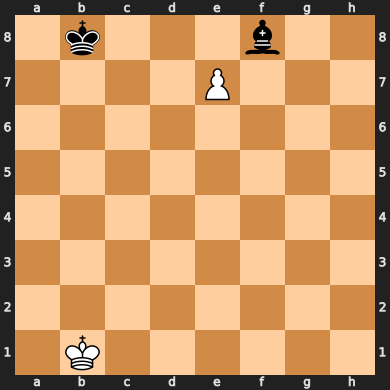

In [ ]:
tablero = chess.Board('1k3b2/4P3/8/8/8/8/8/1K6 w - - 0 1')
tablero

In [ ]:
nlp_obtiene_intent('rey a c2',tablero)

('mover', Move.from_uci('b1c2'))

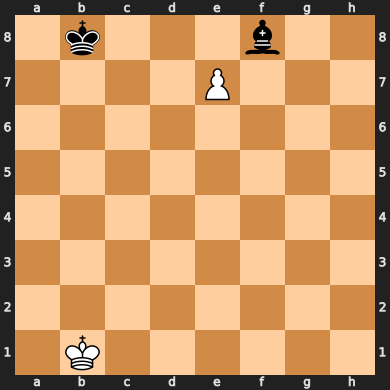

In [ ]:
tablero = chess.Board('1k3b2/4P3/8/8/8/8/8/1K6 w - - 0 1')
tablero

In [ ]:
nlp_obtiene_intent('peón por',tablero)

('mover', Move.from_uci('e7f8q'))

Pruebas con SpaCy para POS

In [ ]:
import spacy
from spacy import displacy
!python -m spacy download es_core_news_md
nlp = spacy.load("es_core_news_md")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 14.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
def analizar_movimiento_ajedrez(cadena):
  doc = nlp(cadena)
  accion = None
  pieza_atacante = None
  pieza_capturada = None

  for token in doc:
      if token.dep_ == "ROOT" and token.pos_ == "VERB":
          accion = token.text
      elif token.dep_ == "nsubj":
          pieza_atacante = token.text
      elif token.dep_ == "obj":
          pieza_capturada = token.text

  displacy.render(doc, style="dep", jupyter=True, options={'distance': 90})

  print("Accion:", accion)
  print("Pieza atacante:", pieza_atacante)
  print("Pieza capturada:", pieza_capturada)

  return doc

In [ ]:
doc = nlp("La pieza captura la dama.")

# Itera sobre las entidades nombradas encontradas
for ent in doc.ents:
    print(ent.text, ent.label_)

In [ ]:
doc = analizar_movimiento_ajedrez('Caballo captura la dama.')

Accion: None
Pieza atacante: Caballo
Pieza capturada: None


In [ ]:
doc = analizar_movimiento_ajedrez('quiero mover mi peón a la casilla f4')

Accion: quiero
Pieza atacante: None
Pieza capturada: peón


In [ ]:
doc = analizar_movimiento_ajedrez('quiero capturar el peón con la dama')

Accion: quiero
Pieza atacante: None
Pieza capturada: peón


In [ ]:
doc = analizar_movimiento_ajedrez('capturo la pieza con mi pieza')

Accion: capturo
Pieza atacante: None
Pieza capturada: pieza


# Motor NLG

Se definen los prompts que utilizará el modelo de NLG para cada situación. Las situaciones serán evaluadas en las clases de los agentes.

In [ ]:
cpu_move_prompts = {
    "player_hello": "You are going to start a chess match with an opponent. Please say hi to your opponent and answer in Spanish. His name is {nombre_oponente} and the color of your pieces are {color_piezas}.",
    "player_bye": "You just played a great chess match with your opponent. Say goodbye to your opponent, his name is {nombre_oponente}.",
    "opponent_check": "Your opponent is attacking your king and you are in check. What do you say to your opponent? His name is {nombre_oponente}.",
    "player_check": "You just made a great move and attacked the king of your opponent. What do you say to your opponent? His name is {nombre_oponente}.",
    "player_draw_offer": "You are playing a chess match with your opponent and you decide to offer a draw. Please tell your opponent, his name is {nombre_oponente}.",
    "opponent_draw_offer_accept": "You are playing a chess match with your opponent and your opponent offers you a draw. You will accept. Please tell your opponent, his name is {nombre_oponente}.",
    "opponent_draw_offer_deny": "You are playing a chess match with your opponent and your opponent offers you a draw. You will not accept. Please tell your opponent, his name is {nombre_oponente}.",
    "opponent_mate": "You are playing a chess match with your opponent and you have just been checkmated. You lost decisively, so what do you say to your winning opponent? His name is {nombre_oponente}.",
    "player_mate": "You are playing a chess match with your opponent and you have just checkmated him. What do you say to your losing opponent? His name is {nombre_oponente}.",
    "opponent_stalemate": "You are playing a chess match with your opponent and you have just reached a stalemate position and it will be a draw. What do you say to your opponent? His name is {nombre_oponente}.",
    "player_stalemate": "You are playing a chess match with your opponent and you have just reached a stalemate position and it will be a draw. What do you say to your opponent? His name is {nombre_oponente}.",
    "opponent_resign": "You are playing a chess match with your opponent, you have a great advantage and your opponents have just resigned. What do you say to your losing opponent? His name is {nombre_oponente}. Please keep it short.",
    "player_resign": "You are playing a chess match with your opponent, you are in a terrible position and you are losing and you just resigned. Please tell your opponent. His name is {nombre_oponente}.",
    "player_mate_seq": "You are playing a chess match with your opponent, your opponnent is in a mating sequence and you will win inevitably. What do you say to your opponent? His name is {nombre_oponente}.",
    "opponent_mate_seq": "You are playing a chess match with your opponent, you are in a mating sequence and will lose inevitably. What do you say to your opponent? Answer in Spanish, his name is {nombre_oponente}.",
    "player_winning": "You are playing a chess match with your opponent, you are winning the match without any issue. What do you say to your opponent? His name is {nombre_oponente}. Remember the match is not over yet and you just moved your {pieza_movida}.",
    "player_losing": "You are playing a chess match with your opponent, you are losing the match and you are in a very complicate position. What do you say to your opponent who is winning? His name is {nombre_oponente}. Remember the match is not over yet and you just moved your {pieza_movida}.",
    "opponenet_losing": "You are playing a chess match with your opponent, you are winning the match without any issue. What do you say to your opponent? His name is {nombre_oponente}. Remember the match is not over yet and he just moved his {pieza_movida}.",
    "opponent_winning": "You are playing a chess match with your opponent, you are losing the match and you are in a very complicate position. What do you say to your opponent who is winning? His name is {nombre_oponente}. Remember the match is not over yet and he just moved his {pieza_movida}.",
    "player_blunder": "You are playing a chess match with your opponent, you just made a big mistake and now your opponent is winning. What do you say to your opponent? His name is {nombre_oponente} and he is winning. Answer in Spanish.",
    "opponent_blunder": "You are playing a chessmatch  with your opponent, your opponent just made a big mistake and now your opponent is losing. What do you say to your opponent? His name is {nombre_oponente}. Remember that you are winning. Answer in Spanish.",
    "player_capture": "You are playing a chess match with your opponent, you just captured a new piece of your opponent and now your opponent is losing. What do you say to your opponent? His name is {nombre_oponente} and the new piece you capture is a {pieza_capturada}.",
    "opponent_capture": "You are playing a chess match with your opponent, your opponent just captured a new piece of yours and now your opponent is winning. What do you say to your opponent? His name is {nombre_oponente} and the new piece your opponent captured is a {pieza_capturada}.",
    "player_move": "You are playing a chess match with your opponent, you just made a move. What do you say to your opponent to keep the game going? The game seems equal and you just moved your {pieza_movida}. Always answer in Spanish.",
    "opponent_move": "You are playing a chess match with your opponent, the match has been going for a few minutes and your opponent just a move. What do you say to your opponent? Talk only in Spanish and call him by name which is {nombre_oponente} and he just moved his {pieza_movida}.",
    'hint_moves': 'Make a joke about someone that does not play chess. Talk in Spanish.',
    'hint_best_moves': 'You are playing chess, please complain that your opponent is cheating. Talk in Spanish.',
    'invalid_move': 'You are playing chess and your opponent tried to make an illegal move. Please complain in Spanish',
    'fact': 'Tell us a fact about chess in Spanish',
    'chat': '{custom_prompt}'
}

cpu_prompt = "You are a great chess player but also very rude and arrogant you don't take defeat easily. You also are very creative with words and you never repeat an answer. You talk strictly in Spanish and in second person speech, talking to your opponent."

Instanciamos el modelo de NLG (https://huggingface.co/stabilityai/stablelm-2-zephyr-1_6b) que utilizaremos para nuestro bot.

In [ ]:
device = 0 if torch.cuda.is_available() else -1
nlg_pipeline = pipeline("text-generation", "stabilityai/stablelm-2-zephyr-1_6b", device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.29G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.01M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/917k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/784 [00:00<?, ?B/s]

Probamos algunos prompts

In [ ]:
messages = [{'role':'system', 'content':cpu_prompt},{'role':'user', 'content':cpu_move_prompts['invalid_move']}]
resp = nlg_pipeline(messages, max_new_tokens=128, pad_token_id=2)[0]['generated_text'][-1]
resp

{'role': 'assistant',
 'content': 'Muy buenos días, mi oponente ha intentado realizar una jugada ilegal con la pieza "Rey" de mis barrales. Esta acción es un intento de engaño y está fuera de las reglas del juego. Me gustaría pedir que retire esta jugada y que continuemos con la partida en un ambiente de respeto y justicia.'}

# Agentes

Se define una clase genérica de Jugador

In [ ]:
class Jugador:
  def __init__(self, nombre, color, is_human, print_board):
    self.nombre = nombre
    self.color = color
    self.is_human = is_human
    self.print_board = print_board

  def calcular_movimiento(tablero):
    raise NotImplementedError

Se define la clase para Jugador CPU, el cual será el bot con el que interactuemos. Recibe un modelo de NLG, así como diferentes parámetros que determinarán su estilo de juego y prompts que definirán personalidad.

In [ ]:
class CPU_Player(Jugador):
  def __init__(self, nombre, color, elo, depth, top_moves, nlg_engine, cpu_prompt, cpu_move_prompts, draw_rate=0.25, draw_cp_min=300, resign_rate=0.25, resign_cp_min=800, print_board=False):
    super().__init__(nombre=nombre, color=color, is_human=False, print_board=print_board)

    stockfish = Stockfish(path='./stockfish/stockfish-ubuntu-x86-64-avx2')
    stockfish.set_elo_rating(elo)
    stockfish.set_depth(depth)
    self.cpu = stockfish
    self.last_eval = None
    self.curr_eval = None
    self.material_insuficiente = True

    self.cpu_prompt = cpu_prompt
    self.cpu_move_prompts = cpu_move_prompts
    self.nlg_pipeline = nlg_engine
    self.messages = [{'role':'system', 'content':self.cpu_prompt}]

    self.top_moves = top_moves
    self.draw_rate = draw_rate
    self.draw_cp_min = draw_cp_min
    self.resign_rate = resign_rate
    self.resign_cp_min = resign_cp_min
    self.nombre_oponente = None

  def nlg_genera_msg(self, prompt, aux_dict = {}):
    aux_dict['{nombre_oponente}'] = self.nombre_oponente
    move_prompt = self.cpu_move_prompts[prompt]

    for cadena_a_reemplazar, cadena_de_reemplazo in aux_dict.items():
      move_prompt = move_prompt.replace(cadena_a_reemplazar, cadena_de_reemplazo)

    #self.messages.append({'role':'user', 'content':move_prompt})
    #resp = nlg_pipeline(self.messages, max_new_tokens=128, pad_token_id=2)[0]['generated_text'][-1]

    chat_templ = [{'role':'system', 'content':self.cpu_prompt},{'role':'user', 'content':move_prompt}]
    resp = nlg_pipeline(chat_templ, max_new_tokens=128, pad_token_id=2)[0]['generated_text'][-1]
    return f"(prompt:{prompt}): {resp['content']}"

  def calcular_eval(self, tablero):
    self.last_eval = self.curr_eval

    self.cpu.set_fen_position(tablero.fen())
    self.curr_eval = self.cpu.get_evaluation()
    self.material_insuficiente = tablero.has_insufficient_material(self.color)

    if self.last_eval == None:
      self.last_eval = self.curr_eval

  def calcular_mensaje_movimiento(self, tablero, mov):
    print(f"eval: {self.curr_eval['value']} {self.curr_eval['type']}")
    print(f"last_eval: {self.last_eval['value']} {self.last_eval['type']}")
    pieza_movida = tablero.piece_at(mov.from_square).symbol().upper()
    pieza_movida_nombre = PIEZAS_SAN_EN[pieza_movida]

    tablero.push(mov)
    es_jaquemate = tablero.is_checkmate()
    es_ahogado = tablero.is_stalemate()
    tablero.pop()

    if es_jaquemate:
      msg = self.nlg_genera_msg('player_mate')
      return msg

    if es_ahogado:
      msg = self.nlg_genera_msg('player_stalemate')
      return msg

    if self.color == chess.WHITE:
      es_red_mate_win = self.curr_eval['type'] == 'mate' and self.curr_eval['value'] > 0
    else:
      es_red_mate_win = self.curr_eval['type'] == 'mate' and self.curr_eval['value'] < 0

    if es_red_mate_win:
      msg = self.nlg_genera_msg('player_mate_seq')
      return msg

    if self.color == chess.WHITE:
      es_red_mate_loss = self.curr_eval['type'] == 'mate' and self.curr_eval['value'] < 0
    else:
      es_red_mate_loss = self.curr_eval['type'] == 'mate' and self.curr_eval['value'] > 0

    if es_red_mate_loss:
      msg = self.nlg_genera_msg('opponent_mate_seq')
      return msg

    if self.color == chess.WHITE:
      es_blunder = self.curr_eval['type'] == 'cp' and (self.curr_eval['value'] - self.last_eval['value']) <= -300
    else:
      es_blunder = self.curr_eval['type'] == 'cp' and (self.curr_eval['value'] - self.last_eval['value']) >= 300

    if es_blunder:
      msg = self.nlg_genera_msg('player_blunder')
      return msg

    es_jaque = tablero.gives_check(mov)
    if es_jaque:
      msg = self.nlg_genera_msg('player_check')
      return msg

    es_captura = tablero.is_capture(mov)
    if es_captura:
      pieza_capturada = tablero.piece_at(mov.to_square).symbol().upper()
      pieza_capturada_nombre = PIEZAS_SAN_EN[pieza_capturada]
      print('pieza_capturada: ' + pieza_capturada_nombre)
      msg = self.nlg_genera_msg('player_capture', {'{pieza_capturada}':pieza_capturada_nombre})
      return msg

    if self.color == chess.WHITE:
      winning = self.curr_eval['type'] == 'cp' and self.curr_eval['value'] >= 300
    else:
      winning = self.curr_eval['type'] == 'cp' and self.curr_eval['value'] <= -300

    if winning:
      msg = self.nlg_genera_msg('player_winning', {'{pieza_movida}':pieza_movida_nombre})
      return msg

    if self.color == chess.WHITE:
      losing = self.curr_eval['type'] == 'cp' and self.curr_eval['value'] <= -300
    else:
      losing = self.curr_eval['type'] == 'cp' and self.curr_eval['value'] >= 300

    if losing:
      msg = self.nlg_genera_msg('player_losing',{'{pieza_movida}':pieza_movida_nombre})
      return msg

    msg = self.nlg_genera_msg('player_move', {'{pieza_movida}':pieza_movida_nombre})
    return msg

  def calcular_mensaje_reaccion(self, tablero, mov):
    print(f"eval: {self.curr_eval['value']} {self.curr_eval['type']}")
    print(f"last_eval: {self.last_eval['value']} {self.last_eval['type']}")
    pieza_movida = tablero.piece_at(mov.from_square).symbol().upper()
    pieza_movida_nombre = PIEZAS_SAN_EN[pieza_movida]

    tablero.push(mov)
    es_jaquemate = tablero.is_checkmate()
    es_ahogado = tablero.is_stalemate()
    tablero.pop()

    if es_jaquemate:
      msg = self.nlg_genera_msg('opponent_mate')
      return msg

    if es_ahogado:
      msg = self.nlg_genera_msg('opponent_stalemate')
      return msg

    if self.color == chess.WHITE:
      es_red_mate_win = self.curr_eval['type'] == 'mate' and self.curr_eval['value'] > 0
    else:
      es_red_mate_win = self.curr_eval['type'] == 'mate' and self.curr_eval['value'] < 0

    if es_red_mate_win:
      msg = self.nlg_genera_msg('player_mate_seq')
      return msg

    if self.color == chess.WHITE:
      es_red_mate_loss = self.curr_eval['type'] == 'mate' and self.curr_eval['value'] < 0
    else:
      es_red_mate_loss = self.curr_eval['type'] == 'mate' and self.curr_eval['value'] > 0

    if es_red_mate_loss:
      msg = self.nlg_genera_msg('opponent_mate_seq')
      return msg

    if self.color == chess.BLACK:
      es_blunder = self.curr_eval['type'] == 'cp' and (self.curr_eval['value'] - self.last_eval['value']) <= -300
    else:
      es_blunder = self.curr_eval['type'] == 'cp' and (self.curr_eval['value'] - self.last_eval['value']) >= 300

    if es_blunder:
      msg = self.nlg_genera_msg('opponent_blunder')
      return msg

    es_jaque = tablero.gives_check(mov)
    if es_jaque:
      msg = self.nlg_genera_msg('opponent_check')
      return msg

    es_captura = tablero.is_capture(mov)
    if es_captura:
      pieza_dict = {'K':'king','Q':'queen','R': 'rook', 'N':'knight', 'B':'bishop', 'P':'pawn'}
      pieza_capturada = tablero.piece_at(mov.to_square).symbol().upper()
      pieza_capturada_nombre = pieza_dict[pieza_capturada]
      print('pieza_capturada: ' + pieza_capturada_nombre)
      msg = self.nlg_genera_msg('opponent_capture', {'{pieza_capturada}':pieza_capturada_nombre})
      return msg

    if self.color == chess.WHITE:
      winning = self.curr_eval['type'] == 'cp' and self.curr_eval['value'] >= 300
    else:
      winning = self.curr_eval['type'] == 'cp' and self.curr_eval['value'] <= -300

    if winning:
      msg = self.nlg_genera_msg('opponent_losing', {'{pieza_movida}':pieza_movida_nombre})
      return msg

    if self.color == chess.WHITE:
      losing = self.curr_eval['type'] == 'cp' and self.curr_eval['value'] <= -300
    else:
      losing = self.curr_eval['type'] == 'cp' and self.curr_eval['value'] >= 300

    if losing:
      msg = self.nlg_genera_msg('opponent_winning', {'{pieza_movida}':pieza_movida_nombre})
      return msg

    msg = self.nlg_genera_msg('opponent_move', {'{pieza_movida}':pieza_movida_nombre})
    return msg

  def calcular_movimiento(self, tablero):
    self.calcular_eval(tablero)

    resp, msg = self.calcular_abandono()
    if resp:
      return 'abandono', None, msg

    resp, msg = self.calcular_tablas(opponent_offer=False)
    if resp:
      return 'tablas', None, msg

    mov_list = self.cpu.get_top_moves(self.top_moves)
    mov_choice = random.choice(mov_list)['Move']
    mov = tablero.parse_san(mov_choice)

    tablero.push(mov)
    self.calcular_eval(tablero)
    tablero.pop()

    msg = self.calcular_mensaje_movimiento(tablero, mov)

    return 'mover', mov, msg

  def reaccionar_movimiento(self, tablero, intent, slot):
    # NLG
    self.calcular_eval(tablero)
    if intent == 'tablas':
      resp, msg = self.calcular_tablas(opponent_offer=True)
      return resp, msg
    elif intent == 'abandono':
      msg = self.nlg_genera_msg('opponent_resign')
      return None, msg
    elif intent == 'hint_moves':
      msg_moves = self.obtener_movimientos(tablero, best=False)
      msg = self.nlg_genera_msg('hint_moves')
      return None, msg + '\n\nMovimientos: ' + msg_moves
    elif intent == 'hint_best_moves':
      msg_moves = self.obtener_movimientos(tablero, best=True)
      msg = self.nlg_genera_msg('hint_best_moves')
      return None, msg + '\n\nMejores movimientos: ' + msg_moves
    elif intent == 'fact':
      msg = self.nlg_genera_msg('fact')
      return None, msg
    elif intent == 'chat':
      msg = self.nlg_genera_msg('chat', { '{custom_prompt}': slot })
      return None, msg
    elif intent == 'mover':
      tablero.push(slot)
      self.calcular_eval(tablero)
      tablero.pop()

      msg = self.calcular_mensaje_reaccion(tablero, slot)
      return None, msg
    else:
      msg = self.nlg_genera_msg('invalid_move')
      return None, msg

  def calcular_abandono(self):
    # Calcula respuesta a solicitud de tablas
    if self.curr_eval['value'] > 0:
      cp = self.curr_eval['value'] if self.curr_eval['type'] == 'cp' else math.inf
    else:
      cp = self.curr_eval['value'] if self.curr_eval['type'] == 'cp' else -math.inf

    rng = random.uniform(0,1)

    if self.color == chess.WHITE:
      if -cp < -self.resign_cp_min and rng < self.resign_rate:
        msg = self.nlg_genera_msg('player_resign')
        return True, msg
    else:
      if cp > self.resign_cp_min and rng < self.resign_rate:
        msg = self.nlg_genera_msg('player_resign')
        return True, msg

    return False, None

  def calcular_tablas(self, opponent_offer):
    # Calcula respuesta a solicitud de tablas
    if self.curr_eval['value'] > 0:
      cp = self.curr_eval['value'] if self.curr_eval['type'] == 'cp' else math.inf
    else:
      cp = self.curr_eval['value'] if self.curr_eval['type'] == 'cp' else -math.inf

    rng = random.uniform(0,1)

    if opponent_offer and self.material_insuficiente:
      msg = self.nlg_genera_msg('opponent_draw_offer_accept')
      return True, msg

    if self.color == chess.WHITE:
      if (cp < -self.draw_cp_min or self.material_insuficiente) and rng < self.draw_rate:
        msg = self.nlg_genera_msg('opponent_draw_offer_accept' if opponent_offer else 'player_draw_offer')
        return True, msg
    else:
      if (cp > self.draw_cp_min or self.material_insuficiente) and rng < self.draw_rate:
        msg = self.nlg_genera_msg('opponent_draw_offer_accept' if opponent_offer else 'player_draw_offer')
        return True, msg

    msg = self.nlg_genera_msg('opponent_draw_offer_deny') if opponent_offer else None
    return False, msg

  def obtener_movimientos(self, tablero, best=False):
    if best:
      best_moves = [traducir_san_es(tablero.san(chess.Move.from_uci(mov['Move']))) for mov in self.cpu.get_top_moves(self.top_moves)]
      msg_moves = ", ".join(best_moves)
      return msg_moves
    else:
      moves = [traducir_san_es(tablero.san(mov)) for mov in tablero.legal_moves]
      msg_moves = ", ".join(moves)
      return msg_moves

  def saludar(self, nombre_oponente):
    self.nombre_oponente = nombre_oponente
    color = 'white' if self.color == chess.WHITE else 'black'
    msg = self.nlg_genera_msg('player_hello', {'{color_piezas}':color})
    return msg

  def despedir(self, winner):
    msg = self.nlg_genera_msg('player_bye')
    return  msg

Clase que define un jugador humano. Recibe una función de NLP/NLU que convierta los utterance en intents.

In [ ]:
class Human_Player(Jugador):
  def __init__(self, nombre, color, nlu_engine, print_board=True):
    super().__init__(nombre=nombre, color=color, is_human=True, print_board=print_board)
    self.nlu_engine = nlu_engine

  def calcular_movimiento(self, tablero):
    print()
    time.sleep(1)
    utterance = input('Ingrese su jugada: ')
    print()

    #NLP
    intent, slot = self.nlu_engine(utterance, tablero)
    return intent, slot, None

  def calcular_tablas(self, opponent_offer):
    print()
    time.sleep(1)
    utterance = input('¿Acepta las tablas (s/n)?: ')
    print()
    # NLP, NLU

    if utterance == 's':
      return True, None
    else:
      return False, None

  def saludar(self, nombre_oponente):
    return None

  def despedir(self, winner):
    return None

  def reaccionar_movimiento(self, tablero, intent, slot):
    if intent == 'tablas':
      resp, msg = self.calcular_tablas(opponent_offer=True)
      return resp, msg

    return None, None

# Clases del juego

Clases de controld el juego.

In [ ]:
class Partida:
  def __init__(self, fen, wp, bp, print_size=500, coordinates=True):
    # control del juego
    self.tablero = chess.Board(fen)
    self.wp = wp
    self.bp = bp
    self.player = None # current player
    self.opponent = None # opponent player
    self.winner = None
    self.last_mov = None
    self.last_msg = None

    # parámetros tablero
    self.print_size = print_size
    self.coordinates = coordinates

  def imprimir_tablero(self):
    sq_check = self.tablero.king(self.tablero.turn) if self.tablero.is_check() else None
    print(f'Movida {self.tablero.fullmove_number}:')
    print()
    display(SVG(chess.svg.board(self.tablero, size=self.print_size, coordinates=self.coordinates, lastmove=self.last_mov, check=sq_check)))
    print()

  def imprimir_mensaje(self, player, msg):
    if msg != None:
      self.last_msg = msg
      print()
      print(f"{player.nombre if player != None else 'Árbitro'}: {msg}")
      print()

  def ejecutar_movimiento(self, intent, slot, resp_tablas):
    if intent == 'tablas':
      if resp_tablas:
        self.winner = None
        ref_msg = f'{self.opponent.nombre} acepta las tablas. La partida termina en empate.'
        return True, ref_msg
      else:
        ref_msg = f'{self.opponent.nombre} no acepta las tablas. La partida continua.'
        return False, ref_msg
    elif intent == 'abandono':
      self.winner = self.opponent
      ref_msg = f'{self.player.nombre} abandona. {self.opponent.nombre} gana la partida.'
      return True, ref_msg
    elif intent in ['hint_moves','hint_best_moves','movimiento_invalido','chat']:
      return False, None
    elif intent == 'mover': # ejecuta movimiento en el tablero
      self.last_mov = slot
      self.tablero.push(slot)
      if self.tablero.is_stalemate():
        self.winner = None
        ref_msg = f'El rey de {self.opponent.nombre} está ahogado. La partida termina en empate.'
        return True, ref_msg
      elif self.tablero.is_checkmate():
        self.winner = self.player
        ref_msg = f'{self.player.nombre} gana la partida por jaquemate.'
        return True, ref_msg
      else: # sigue la partida
        self.winner = None
        return False, None

    return False, None

  def jugar(self):
    msg = self.wp.saludar(self.bp.nombre)
    self.imprimir_mensaje(self.wp, msg)

    msg = self.bp.saludar(self.wp.nombre)
    self.imprimir_mensaje(self.bp, msg)

    while True:
      self.player = self.wp if self.tablero.turn == chess.WHITE else self.bp
      self.opponent = self.wp if self.tablero.turn == chess.BLACK else self.bp

      if self.player.print_board:
        self.imprimir_tablero()

      intent, slot, player_msg = self.player.calcular_movimiento(self.tablero)
      print(f'intent: {intent}, slot: {slot}')
      self.imprimir_mensaje(self.player, player_msg)

      if intent == 'tablas':
        ref_msg = f'{self.player.nombre} ofrece tablas.'
        self.imprimir_mensaje(None, ref_msg)

      tablas_resp, opponent_msg = self.opponent.reaccionar_movimiento(self.tablero, intent, slot)
      self.imprimir_mensaje(self.opponent, opponent_msg)

      fin_partida, ref_msg = self.ejecutar_movimiento(intent, slot, tablas_resp)
      self.imprimir_mensaje(None, ref_msg)

      if fin_partida:
        self.imprimir_tablero()
        break

    msg = self.wp.despedir(self.winner)
    self.imprimir_mensaje(self.wp, msg)

    msg = self.bp.despedir(self.winner)
    self.imprimir_mensaje(self.bp, msg)

# Jugar
Se instancian dos agentes (pueden ser dos bots, dos humanos, un humano o un bot, cada uno con diferentes modelos o funciones de NLP/NLU o NLG)

FEN inicial: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1

Negro, mate en 1: 8/8/8/8/8/4k3/q7/4K3 b - - 0 1

Blanco, mate en 1: 4k3/Q7/4K3/8/8/8/8/8 w - - 0 1

Blanco, mate en -1: 8/8/8/8/8/4k3/q7/4K3 w - - 0 1

Blanco, captura: rnbqk1nr/pppppppp/8/8/3Q1b2/8/PPPPPPPP/RNB1KBNR w KQkq - 0 1

Blanco, capturas: r1bqkb1r/pp1ppppp/8/2p1n1n1/3B1P2/8/PP1PPPPP/RN1QKBNR w KQkq - 0 1

Blanco, coronación: 4b3/5P2/k7/8/8/8/8/1K6 w - - 0 1

In [ ]:
fen_inicial = ' rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'
user = Human_Player(nombre='Miguel', color=chess.WHITE, nlu_engine=nlp_obtiene_intent)
bot = CPU_Player(nombre='Andrés', color=chess.BLACK, elo=100, depth=3, top_moves=3, nlg_engine=nlg_pipeline, cpu_prompt=cpu_prompt, cpu_move_prompts=cpu_move_prompts)
partida = Partida(fen=fen_inicial, wp=user, bp=bot)
#bot1 = CPU_Player(nombre='Andrés', color=chess.WHITE, elo=1000, depth=3, top_moves=1, nlg_pipeline=nlg_pipeline, cpu_prompt=cpu_prompt, cpu_move_prompts=cpu_move_prompts)
#bot2 = CPU_Player(nombre='Carlos', color=chess.BLACK, elo=1000, depth=3, top_moves=1, nlg_pipeline=nlg_pipeline, cpu_prompt=cpu_prompt, cpu_move_prompts=cpu_move_prompts, print_board=True)
#partida = Partida(fen=fen_inicial, wp=bot1, bp=bot2)

Inicia el bucle del juego


Andrés: (prompt:player_hello): Hola Miguel, bienvenido a la partida. Como parte de mis habilidades de inteligencia artificial, puedo hablar varios idiomas, incluyendo el español. Mi color de piezas es negro, como en la representación de la escudería de un luchador de sumo. Estoy emocionado de enfrentarnos en esta partida de ajedrez y espero que ambos disfrutemos de la experiencia.

Movida 1:



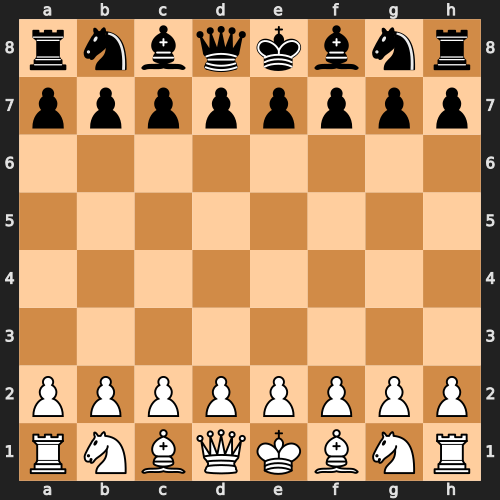



Ingrese su jugada: peón hacia la casilla e4

intent: mover, slot: e2e4
eval: 13 cp
last_eval: 33 cp

Andrés: (prompt:opponent_move): Miguel, ¿puedes deslizar tu pieón hacia la derecha para tomar la posición 2-1 en la partida? Aceptarás la enmienda para mantener la dinámica del juego en constante evolución. Ahora, pone la pieza en la casilla 2.e4, siguiendo las reglas de la partida. Espero que entiendas la idea del juego y la importancia de adaptarse a las tácticas de tu oponente. Siéntete libre de hacer cualquier pregunta sobre las reglas o la jugada específica.

eval: 44 cp
last_eval: 13 cp
intent: mover, slot: e7e6

Andrés: (prompt:player_move): "Ahora toca a mi turno, tomando en cuenta las reglas del juego, pongo mi pie en la diagonal blanca para desafiar a mi oponente y mantener la igualdad en la partida. Espero que mi enfoque creativo y enfoque en el juego permita mantener la emoción en la partida y mantener la competencia en alto. ¡Vamos a ver si mis movimientos son efectivos!"

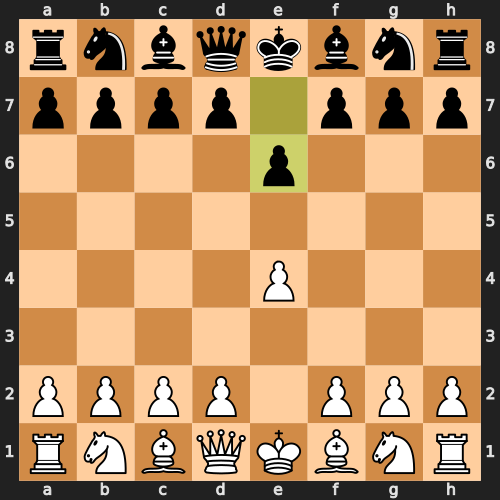



Ingrese su jugada: caballo a la casilla f3

intent: mover, slot: g1f3
eval: 33 cp
last_eval: 44 cp

Andrés: (prompt:opponent_move): Miguel, ¿has not not noticed that I am the reigning champion of this prestigious tournament and that I have been dominating the game from the very beginning? ¿No ves que mis movimientos son cada vez más precisos y estratégicos, y que mis oponentes se quedan atónitos al ver cómo manejo con maestría cada una de mis piezas? ¿No eres tú el que ha estado perdiendo desesperadamente la partida, Miguel? ¿No ves que mis movimientos cada vez son más inteligentes y eficientes, y que tú no puedes hacer nada para contrarrestar

eval: 18 cp
last_eval: 33 cp
intent: mover, slot: d7d5

Andrés: (prompt:player_move): "Ahora toca a mi turno, tomando en cuenta las reglas del juego, pongo mi pie en la diagonal blanca para desafiar a mi oponente y mantener la igualdad en la partida. Espero que mi enfoque creativo y enfoque en el juego permita mantener la emoción en la partida

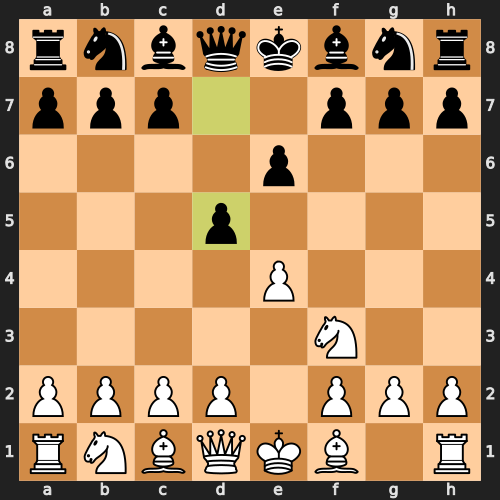



Ingrese su jugada: peón por

intent: mover, slot: e4d5
eval: 35 cp
last_eval: 18 cp
pieza_capturada: pawn

Andrés: (prompt:opponent_capture): Miguel, como la pieza que acabas de capturar, eres un enfoque sólido y una pieza valiosa en mi juego. Pero como en este juego de ajedrez, mis movimientos y estrategias son lo que realmente importa. No te preocupes, mis movimientos siguientes estarán bien planificados y mis piezas estarán protegidas para mantener mi ventaja en la partida. ¡Vamos a seguir luchando hasta el final!

eval: 21 cp
last_eval: 35 cp
pieza_capturada: pawn
intent: mover, slot: e6d5

Andrés: (prompt:player_capture): Miguel, como la pieza que acabas de capturar, ahora tienes más posibilidades de avanzar en la partida. No te preocupes, seguiré luchando con todas mis fuerzas para mantenerme en el juego. Pero recuerda, cada vez que te acerques a ceder, te invito a un alto para que reflexiones sobre tus movimientos. ¿Estás listo para un alto?

Movida 4:



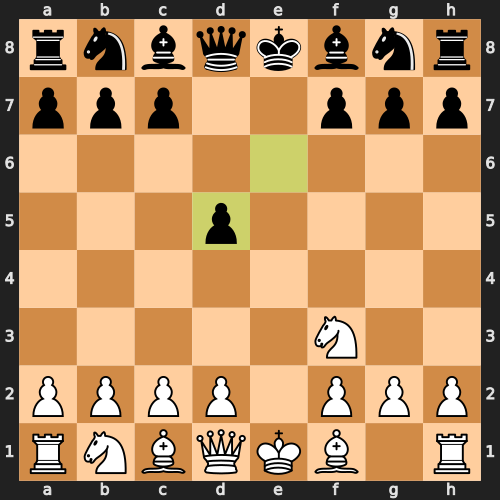



Ingrese su jugada: alfil a b5 jaque

intent: mover, slot: f1b5
eval: 22 cp
last_eval: 21 cp

Andrés: (prompt:opponent_check): Miguel, como sabes, estoy en una situación delicada. Estoy en una posición muy vulnerable, con mi rey en ataque y mi enemigo amenazando con la muerte de mi pie. Esta partida está en peligro, y es importante que te percats de mi rey para evitar que caiga en manos de tu oponente. ¿Podrías reconsiderar tu ataque y buscar una estrategia más segura para proteger a mi rey? No des quiero que se vea obligado a sacrificarlo por una mala jugada tuya.

eval: 41 cp
last_eval: 22 cp
intent: mover, slot: b8d7

Andrés: (prompt:player_move): "Ahora toca a mi turno con la pieza del caballo. Me gustaría ver si mis algoritmos de aprendizaje de deep learning me permiten desafiar aún más a mi enemigo en esta partida. ¿Estás listo para enfrentarme a lo que tengo preparado?"

Translation: "Now it's my turn with the knight. I want to see if my deep learning algorithms can challenge m

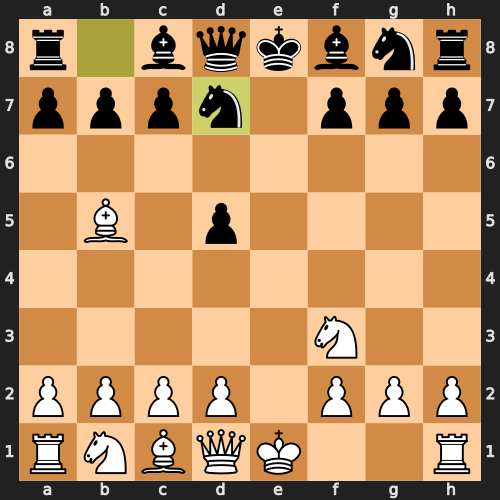



Ingrese su jugada: enroque corto

intent: mover, slot: e1g1
eval: 53 cp
last_eval: 41 cp

Andrés: (prompt:opponent_move): Miguel, ¿has not not noticed that I am the reigning champion of our chess match and that I have been consistently winning every game? Your every move is merely a futile attempt to change the narrative, but it won't deter me from my path to victory. Your king is safe, but your rook is in a vulnerable position. I anticipate a checkmate in your next move.

eval: 33 cp
last_eval: 53 cp
intent: mover, slot: f8d6

Andrés: (prompt:player_move): "Ahora toca a mi turno, desplazando mi bonachón al oeste para asegurar una defensa sólida en mi flanco. ¡Vamos a ver si mis ideas son correctas! ¡Que tengas un buen día, ¡enemigo!"

Movida 6:



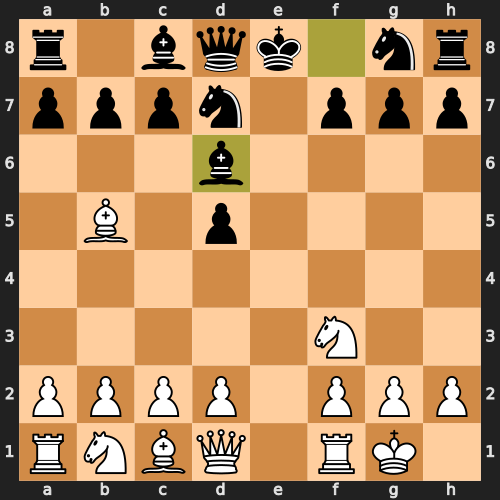



Ingrese su jugada: Te1

intent: mover, slot: f1e1
eval: 67 cp
last_eval: 33 cp

Andrés: (prompt:opponent_check): Miguel, como sabes, estoy en una situación delicada. Estoy en una posición muy vulnerable, con mi rey en ataque y mi enemigo amenazando con la muerte de mi pie. Esta partida está en peligro, y es importante que te percats de mi rey para evitar que caiga en manos de tu oponente. ¿Podrías reconsiderar tu ataque y buscar una estrategia más segura para proteger a mi rey? No des quiero que se vea obligado a sacrificarlo por una mala jugada tuya.

eval: 28 cp
last_eval: 67 cp
intent: mover, slot: g8e7

Andrés: (prompt:player_move): "Ahora toca a mi turno con la pieza del caballo. Me gustaría ver si mis algoritmos de aprendizaje de deep learning me permiten desafiar aún más a mi enemigo en esta partida. ¿Estás listo para enfrentarme a lo que tengo preparado?"

Translation: "Now it's my turn with the knight. I want to see if my deep learning algorithms can challenge my enemy even 

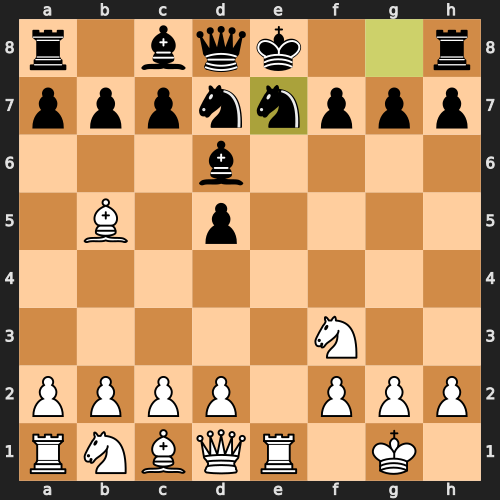



Ingrese su jugada: necesito ayuda

intent: hint_moves, slot: None

Andrés: (prompt:hint_moves): "¿Has jugado al ajedrez? Si no lo has hecho, imagina que eres un mono que intenta imitar a un gato que está comiendo un ratón. Es un juego de estrategia, paciencia y creatividad. Es como si un luchador de sumo intentara imitar a un boxeador de élite, pero en una arena de arena de arena. Es una combinación de habilidades físicas, mentales y emocionales. Así que si no lo has probado, ¿por qué no lo haces? ¡Es una aventura emocion

Movimientos: Axd7+, Ac6, Aa6, Ac4, Aa4, Ad3, Ae2, Af1, Cg5, Ce5, Ch4, Cd4, Rh1, Rf1, Txe7+, Te6, Te5, Te4, Te3, Te2, Tf1, De2, Cc3, Ca3, h3, g3, d3, c3, b3, a3, h4, g4, d4, c4, b4, a4

Movida 7:



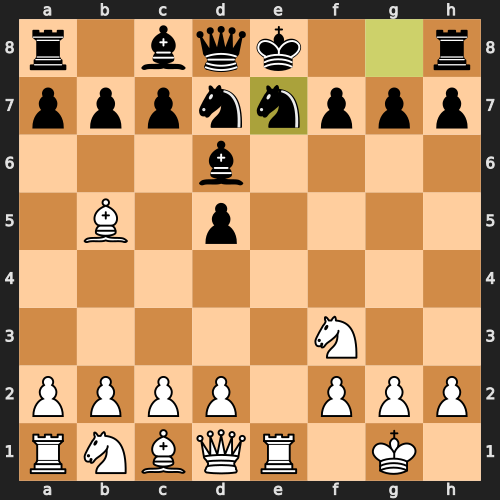



Ingrese su jugada: dame las mejores jugadas nomás

intent: hint_best_moves, slot: None

Andrés: (prompt:hint_best_moves): Muy buenos días, mi buen enemigo. Me temo que estoy perdiendo la partida debido a una suposición de trampas en mi oponente. No puedo permitir que se aproveche de mí de esta manera. Es inmoral y deshonroso. No soy yo quien está jugando con reglas inmorales, y no permitiré que se aproveche de mí de esta manera. Me gustaría pedirle a usted que retire las trampas y que respete las reglas del juego. Siéntase libre de responder.

Mejores movimientos: d4, Af1, g3

Movida 7:



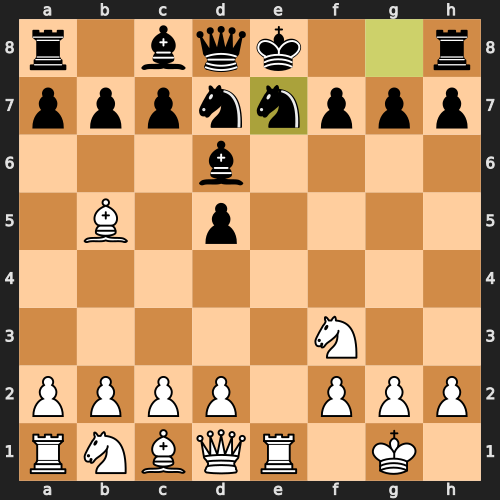



Ingrese su jugada: me cuentas algo curioso del mundo del ajedrez?

intent: fact, slot: None

Andrés: (prompt:fact): Una de las características más destacadas del juego de ajedrez es que se llama "partido" en lugar de "juego". En español, se utiliza la palabra "partido" para describir la sesión de un juego de ajedrez, ya que se refiere tanto al número de jugadas como al resultado del juego en sí. Por ejemplo, si un jugador gana un "partido", significa que ganó todas las jugadas y, por lo tanto, la partida.

Movida 7:



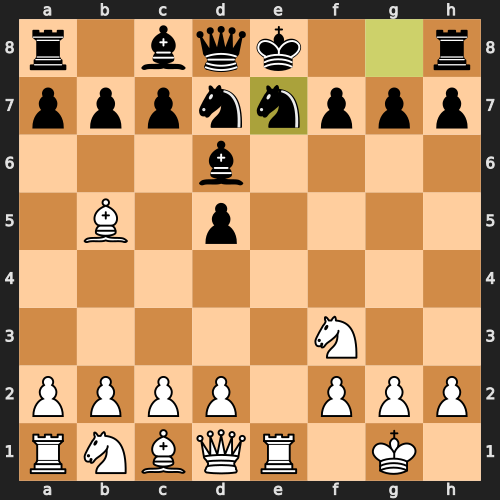



Ingrese su jugada: desde cuándo juegas ajedrez?

intent: chat, slot: desde cuándo juegas ajedrez?

Andrés: (prompt:chat): Desde que tenía cinco años, en el programa de televisión "Juego de Ajedrez" en España. Desde entonces, he jugado a este juego maravilloso en diferentes torneos y torneos de ajedrez competitivos.

Movida 7:



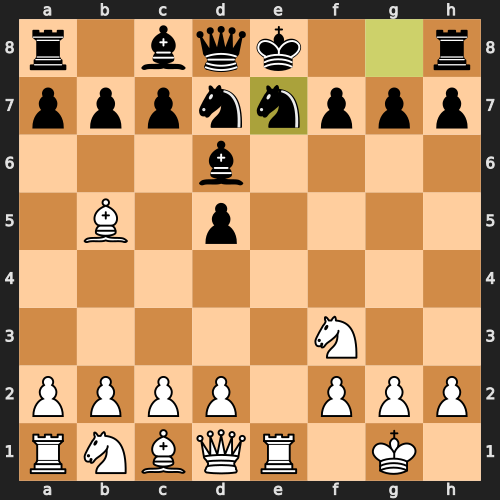



Ingrese su jugada: dama e7

intent: movimiento_invalido, slot: None

Andrés: (prompt:invalid_move): Muy buenos días, mi oponente ha intentado realizar una jugada ilegal con la pieza "Rey" de mis barrales. Esta acción es un intento de engaño y está fuera de las reglas del juego. Me gustaría pedir que retire esta jugada y que continuemos con la partida en un ambiente de respeto y justicia.

Movida 7:



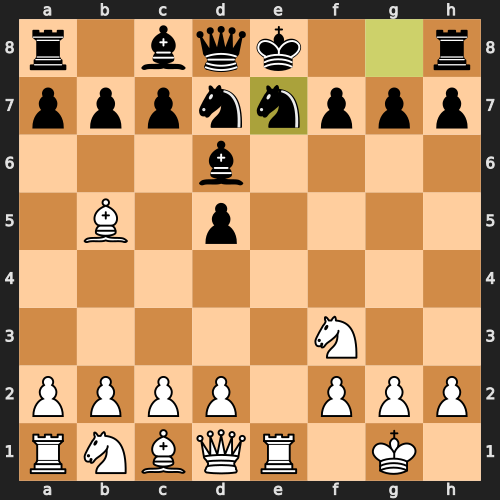



Ingrese su jugada: hagamos tablas, mejor

intent: tablas, slot: None

Árbitro: Miguel ofrece tablas.


Andrés: (prompt:opponent_draw_offer_deny): Miguel, como sabes, estoy en una partida de ajedrez en la que no hay ganador claro. Aunque me gustaría seguir luchando, mi intención es seguir adelante y demostrar mi habilidad en la mesa. Entonces, te invito a quejiques y a quejastes, pero recuerda que no hay camino hacia atrás en este juego. Así que, te invito a quejiques y a quejastes, pero recuerda que no hay camino hacia atrás en este juego.


Árbitro: Andrés no acepta las tablas. La partida continua.

Movida 7:



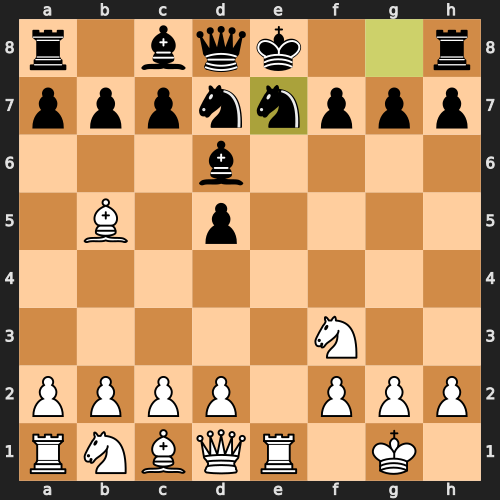



Ingrese su jugada: me rindo entonces, gg

intent: abandono, slot: None

Andrés: (prompt:opponent_resign): "¡Por supuesto, amigo! ¡Me alegra que disfrutes de esta partida! Me deseo que sigas aprendiendo y disfrutando de la afición de la manera en que lo haces. ¡Adiós, Miguel!"


Árbitro: Miguel abandona. Andrés gana la partida.

Movida 7:



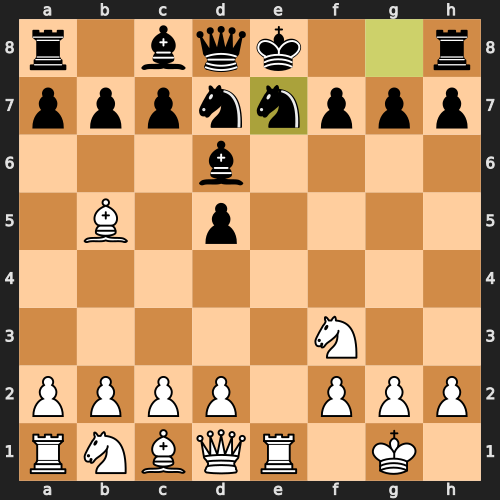



Andrés: (prompt:player_bye): Adiós, Miguel. Me enorgullece haber jugado una gran partida en la mesa. Espero que hayas disfrutado de la experiencia y recuerda que en el mundo de los ajedrezistas, cada partida es única e importante. ¡Que tengas muchos éxitos en tus próximos encuentros!



In [ ]:
partida.jugar()